In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import plotly.express as px

# Set a style for our plots
sns.set_style("darkgrid")

# Load the dataset
df_sl = pd.read_csv('../data/sierraleone-bumbuna.csv')

# --- Chunk 1: Load Data ---
print("--- First 5 Rows ---")
print(df_sl.head())

# --- Chunk 2: Summary Statistics & Missing-Value Report ---

# 1. Summary Statistics
print("\n--- Summary Statistics (df.describe) ---")
print(df_sl.describe())

# 2. Missing-Value Report
print("\n--- Missing Value Report (df.isna().sum()) ---")
missing_values = df_sl.isna().sum()
print(missing_values)

# 3. List columns with >5% nulls
print("\n--- Columns with >5% Missing Values ---")
total_rows = len(df_sl)
missing_percentage = (missing_values / total_rows) * 100
print(missing_percentage[missing_percentage > 5])

--- First 5 Rows ---
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-30 00:01 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.1  0.0     0.0   
1  2021-10-30 00:02 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2  2021-10-30 00:03 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
3  2021-10-30 00:04 -0.7  0.0 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   
4  2021-10-30 00:05 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   

   WSstdev   WD  WDstdev    BP  Cleaning  Precipitation  TModA  TModB  \
0      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
1      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
2      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
3      0.0  0.0      0.0  1002         0            0.1   22.3   22.6   
4      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  

--- 

In [2]:
# Create a copy to avoid changing the original data
df_sl_clean = df_sl.copy()

# 1. Drop the 100% missing columns
cols_to_drop = ['WSgust', 'WSstdev', 'WDstdev', 'Comments']
df_sl_clean = df_sl_clean.drop(cols_to_drop, axis=1)
print(f"Dropped columns: {cols_to_drop}")

# 2. Clean negative irradiance values (clip them at 0)
irradiance_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
for col in irradiance_cols:
    df_sl_clean[col] = df_sl_clean[col].clip(lower=0)

print("Clipped negative irradiance values to 0.")

# 3. Convert 'Timestamp' to datetime object and set as index
df_sl_clean['Timestamp'] = pd.to_datetime(df_sl_clean['Timestamp'])
df_sl_clean = df_sl_clean.set_index('Timestamp')
print("Converted 'Timestamp' to datetime index.")

# 4. Let's check the 'min' values again to confirm our fix
print("\n--- New Summary Statistics (min values only) ---")
print(df_sl_clean[irradiance_cols].min())

Dropped columns: ['WSgust', 'WSstdev', 'WDstdev', 'Comments']
Clipped negative irradiance values to 0.
Converted 'Timestamp' to datetime index.

--- New Summary Statistics (min values only) ---
GHI     0.0
DNI     0.0
DHI     0.0
ModA    0.0
ModB    0.0
dtype: float64


In [3]:
# Columns to check for outliers (we exclude the dropped WSgust)
zscore_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS']

for col in zscore_cols:
    # Calculate z-score and add it as a new column
    df_sl_clean[f'{col}_zscore'] = np.abs(zscore(df_sl_clean[col]))

# Flag rows with Z > 3
z_cols_to_check = [f'{col}_zscore' for col in zscore_cols]
df_sl_clean['is_outlier'] = df_sl_clean[z_cols_to_check].gt(3).any(axis=1)

# Report on our findings
outlier_count = df_sl_clean['is_outlier'].sum()
total_rows = len(df_sl_clean)

print(f"Total rows flagged as outliers (Z-score > 3): {outlier_count}")
print(f"Percentage of data flagged: {(outlier_count / total_rows) * 100:.2f}%")

# Show some of the outlier rows
print("\n--- Example Outlier Rows ---")
print(df_sl_clean[df_sl_clean['is_outlier']].head())

Total rows flagged as outliers (Z-score > 3): 15935
Percentage of data flagged: 3.03%

--- Example Outlier Rows ---
                       GHI    DNI    DHI   ModA   ModB  Tamb    RH   WS  \
Timestamp                                                                 
2021-10-30 10:54:00  814.0  257.0  594.3  878.0  856.0  25.9  85.3  0.5   
2021-10-30 10:55:00  826.0  263.5  599.6  883.0  861.0  26.0  85.4  1.7   
2021-10-30 10:56:00  851.0  285.0  605.9  912.0  890.0  26.0  84.2  1.6   
2021-10-30 10:57:00  823.0  254.8  603.9  878.0  856.0  26.0  85.3  0.8   
2021-10-30 10:58:00  810.0  244.5  598.8  864.0  843.0  26.1  85.7  0.6   

                        WD    BP  ...  Precipitation  TModA  TModB  \
Timestamp                         ...                                
2021-10-30 10:54:00   81.4  1002  ...            0.0   50.4   45.6   
2021-10-30 10:55:00   74.6  1002  ...            0.0   51.6   46.6   
2021-10-30 10:56:00   66.4  1002  ...            0.0   52.4   47.0   
2021-10-

In [4]:
# --- Chunk 5: Export Cleaned Data ---

# Select the original columns to save.
# We must drop the 4 null columns AND 'Timestamp' (which is now the index)
columns_to_save = df_sl.columns.drop(['WSgust', 'WSstdev', 'WDstdev', 'Comments', 'Timestamp'])

# Select only these columns from our cleaned dataframe.
df_to_save = df_sl_clean[columns_to_save]

# Save the cleaned DataFrame to a new CSV file.
output_path = '../data/sierraleone_clean.csv'
df_to_save.to_csv(output_path)

print(f"Successfully saved cleaned data to: {output_path}")

Successfully saved cleaned data to: ../data/sierraleone_clean.csv


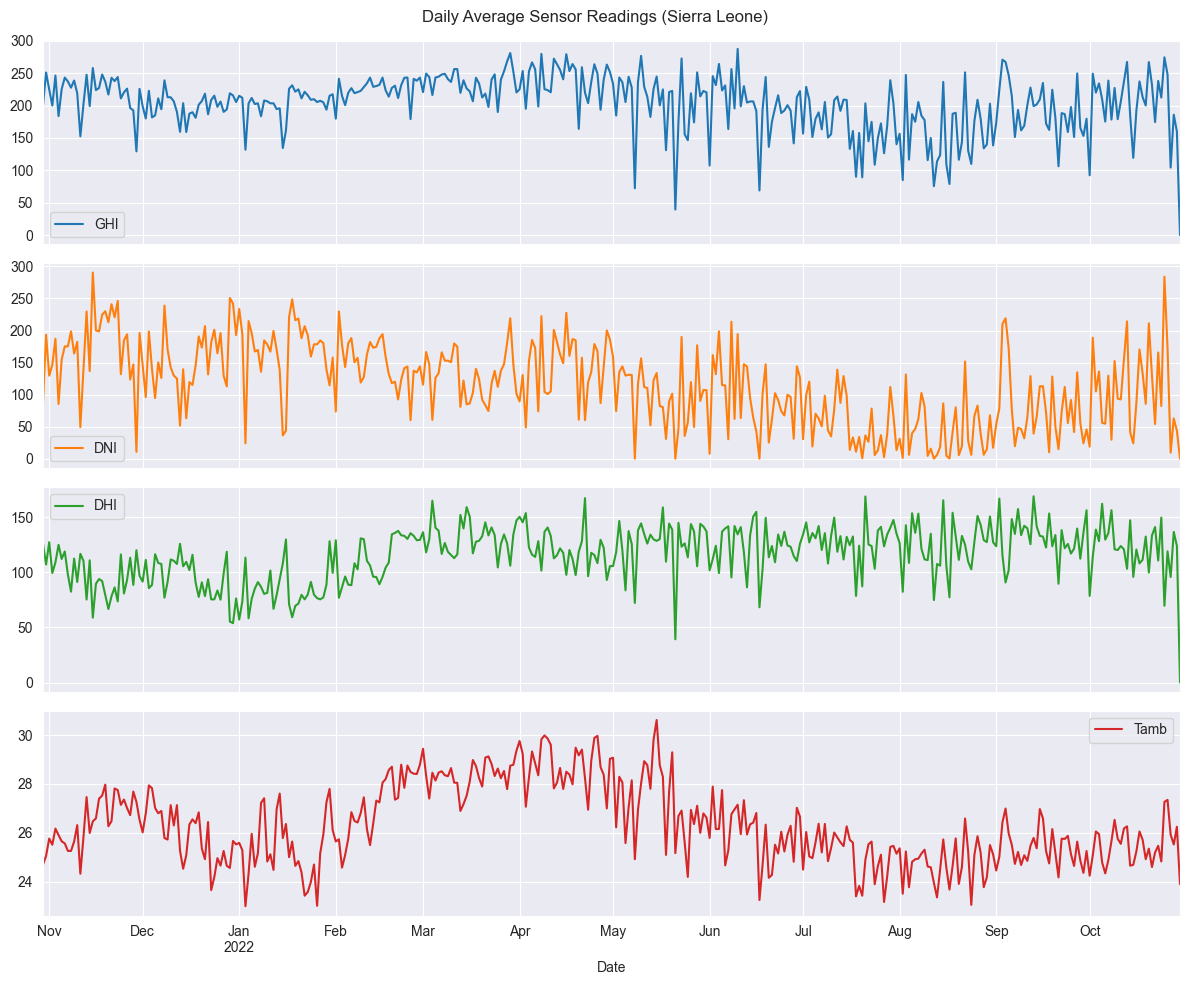


--- Average Sensor Reading by Cleaning Status (Sierra Leone) ---
                ModA        ModB
Cleaning                        
0         206.578599  198.038150
1         273.309252  277.231102


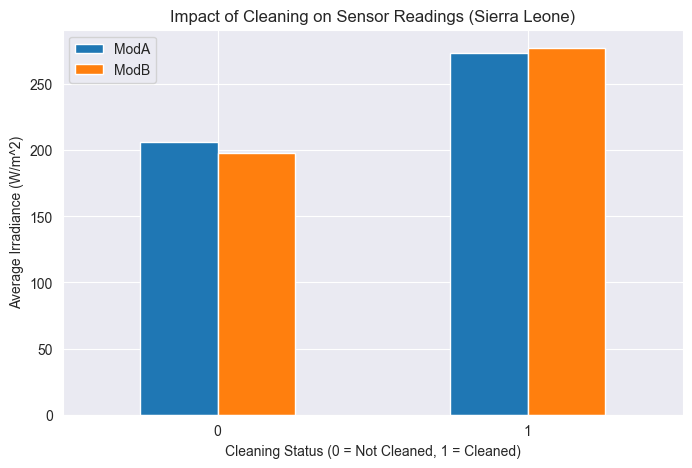

In [5]:
# --- Chunk 6: Time Series Analysis ---

# Resample by Day ('D') and get the mean
df_daily_mean = df_sl_clean.resample('D').mean()

# Columns to plot
plot_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

# Create the plots
df_daily_mean[plot_cols].plot(
    subplots=True,
    figsize=(12, 10),
    title='Daily Average Sensor Readings (Sierra Leone)',
    legend=True
)
plt.xlabel('Date')
plt.tight_layout()
plt.show()


# --- Chunk 7: Cleaning Impact Analysis ---

# Group by the 'Cleaning' flag and calculate the mean
cleaning_impact = df_sl_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

print("\n--- Average Sensor Reading by Cleaning Status (Sierra Leone) ---")
print(cleaning_impact)

# Plot the results
cleaning_impact.plot(
    kind='bar',
    title='Impact of Cleaning on Sensor Readings (Sierra Leone)',
    figsize=(8, 5)
)
plt.ylabel('Average Irradiance (W/m^2)')
plt.xlabel('Cleaning Status (0 = Not Cleaned, 1 = Cleaned)')
plt.xticks(rotation=0)
plt.show()

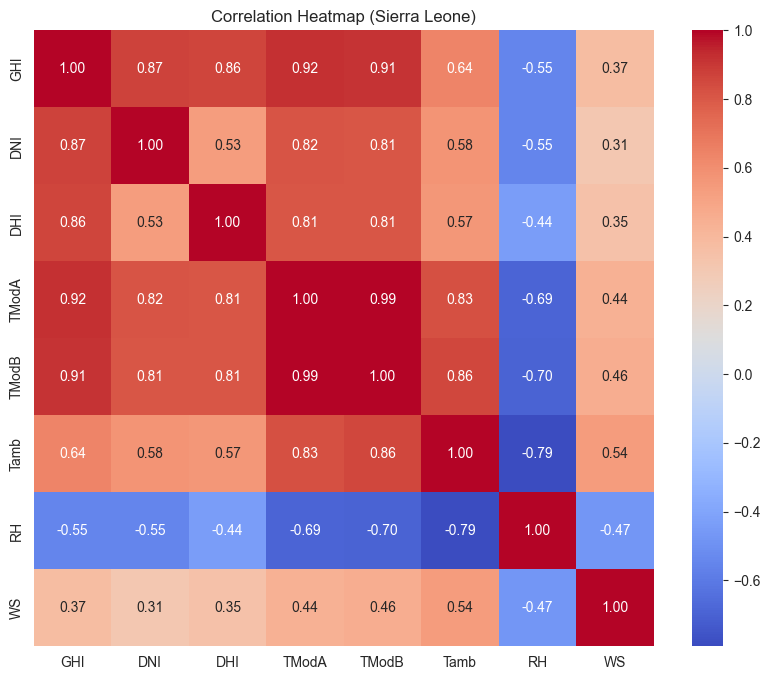

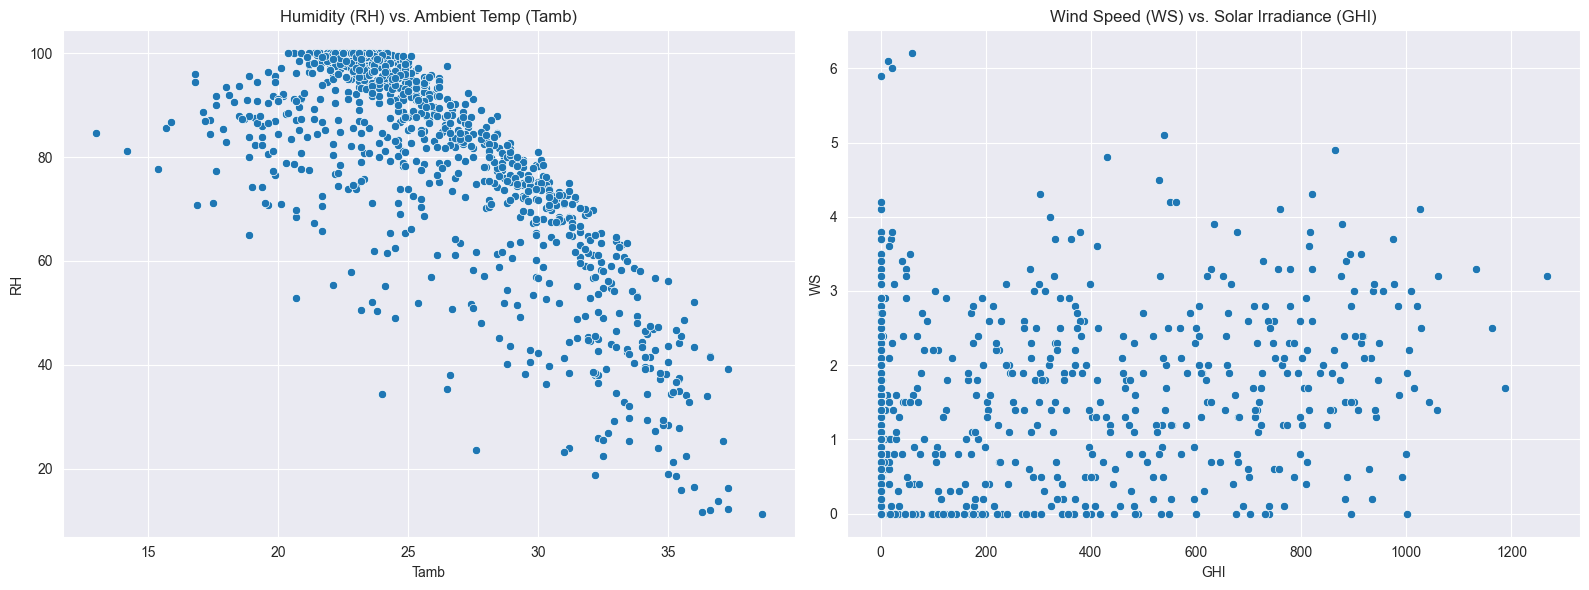

In [6]:
# --- Chunk 8: Correlation Heatmap ---

# Select columns for the correlation heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS']
corr_matrix = df_sl_clean[corr_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)
plt.title('Correlation Heatmap (Sierra Leone)')
plt.show()


# --- Chunk 9: Relationship Scatter Plots ---

# Create a sample of 1000 random points
df_sample = df_sl_clean.sample(n=1000, random_state=42)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: RH vs. Tamb
sns.scatterplot(data=df_sample, x='Tamb', y='RH', ax=ax1)
ax1.set_title('Humidity (RH) vs. Ambient Temp (Tamb)')

# Plot 2: WS vs. GHI
sns.scatterplot(data=df_sample, x='GHI', y='WS', ax=ax2)
ax2.set_title('Wind Speed (WS) vs. Solar Irradiance (GHI)')

plt.tight_layout()
plt.show()

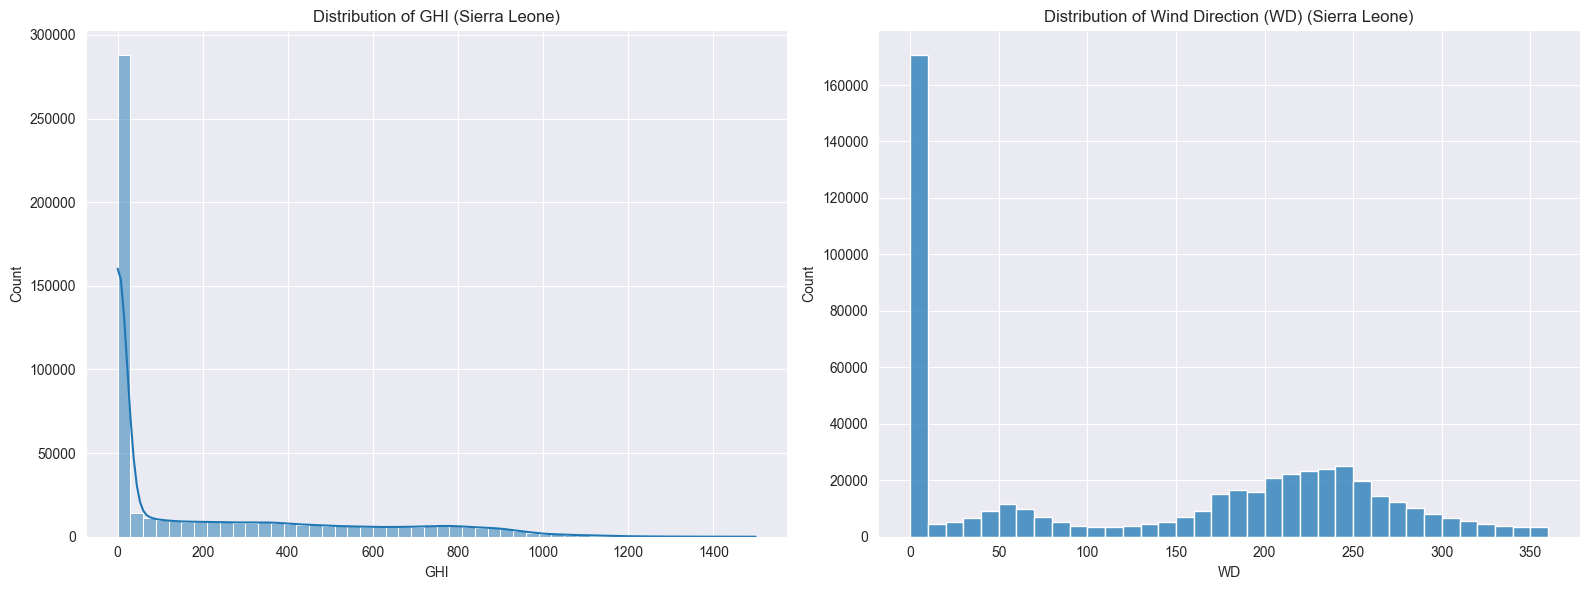

/var/folders/vp/jp6dyn2x6v7dvrtdk8mn938r0000gn/T/ipykernel_23421/850847222.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_rose_data = df_sl_clean.groupby(['WD_binned', 'WS_binned']).size().reset_index(name='count')


In [7]:
# --- Chunk 10: Distribution Histograms ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: GHI Histogram
sns.histplot(data=df_sl_clean, x='GHI', bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of GHI (Sierra Leone)')

# Plot 2: Wind Direction Histogram
sns.histplot(data=df_sl_clean, x='WD', bins=36, kde=False, ax=ax2)
ax2.set_title('Distribution of Wind Direction (WD) (Sierra Leone)')

plt.tight_layout()
plt.show()


# --- Chunk 11: Wind Rose ---

# Bin Wind Direction
df_sl_clean['WD_binned'] = pd.cut(
    df_sl_clean['WD'],
    bins=16,
    labels=['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
            'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
)
# Bin Wind Speed
df_sl_clean['WS_binned'] = pd.cut(
    df_sl_clean['WS'],
    bins=[0, 2, 4, 6, 8, 10, 100],
    labels=['0-2', '2-4', '4-6', '6-8', '8-10', '>10']
)

# Create the Wind Rose data
wind_rose_data = df_sl_clean.groupby(['WD_binned', 'WS_binned']).size().reset_index(name='count')

fig_rose = px.bar_polar(
    wind_rose_data,
    r="count",
    theta="WD_binned",
    color="WS_binned",
    title="Wind Rose for Sierra Leone",
    template="plotly_dark",
    color_discrete_sequence=px.colors.sequential.Plasma_r
)
fig_rose.show()


# --- Chunk 12: Bubble Chart ---

fig_bubble = px.scatter(
    df_sample,
    x="GHI",
    y="Tamb",
    size="RH",
    color="RH",
    title="GHI vs. Ambient Temp (Bubble size = RH) (Sierra Leone)",
    template="plotly_dark",
    size_max=15
)
fig_bubble.update_layout(xaxis_title="GHI (W/m^2)", yaxis_title="Ambient Temp (°C)")
fig_bubble.show()